In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
sns.set(style='darkgrid')

#Importing the data
credit_df = pd.read_csv("german_credit_data.csv", index_col=0)
credit_ml_df = credit_df.copy() # making a copy of the dataframe for feature engineering and transformation
job_category = ['unskilled and non-resident', 'unskilled and resident', 'skilled', 'highly skilled'] # createing categorial values for our column transformer
credit_ml_df['Job'] = credit_ml_df['Job'].replace([0, 1, 2, 3], job_category) # replacing numerical with categorical values
credit_ml_df.head() #display the first 5 rows

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,skilled,own,NaN,little,1169,6,radio/TV,good
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,bad
2,49,male,unskilled and resident,own,little,NaN,2096,12,education,good
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,good
4,53,male,skilled,free,little,little,4870,24,car,bad


In [2]:
credit_ml_df["Saving accounts"].fillna("none", inplace=True)
credit_ml_df["Checking account"].fillna("none", inplace=True)
credit_ml_df.isna().any()

Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts     False
Checking account    False
Credit amount       False
Duration            False
Purpose             False
Risk                False
dtype: bool

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # used to label the target classes
credit_ml_df.Risk = le.fit_transform(credit_ml_df.Risk)
credit_ml_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,skilled,own,none,little,1169,6,radio/TV,1
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,0
2,49,male,unskilled and resident,own,little,none,2096,12,education,1
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,1
4,53,male,skilled,free,little,little,4870,24,car,0


In [4]:
age_interval = (18, 25, 35, 60, 120)
age_cat = ['Student', 'Young', 'Adult', 'Senior'] # creating a new category for age
credit_ml_df["Age Category"] = pd.cut(credit_ml_df.Age, age_interval, labels=age_cat)

credit_interval = (0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000)
credit_cat = ['x < 2500', '2500 <= x < 5000', 
              '5000 <= x < 7500', '7500 <= x < 10000', 
              '10000 <= x < 12500', '12500 <= x < 15000', '15000 <= x < 17500', 'greater than 17500'] # creating a new category for credit amount
credit_ml_df['Credit Category'] = pd.cut(credit_ml_df['Credit amount'], credit_interval, labels=credit_cat)
credit_ml_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age Category,Credit Category
0,67,male,skilled,own,none,little,1169,6,radio/TV,1,Senior,x < 2500
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,0,Student,5000 <= x < 7500
2,49,male,unskilled and resident,own,little,none,2096,12,education,1,Adult,x < 2500
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,1,Adult,7500 <= x < 10000
4,53,male,skilled,free,little,little,4870,24,car,0,Adult,2500 <= x < 5000


In [5]:
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(credit_ml_df['Credit Category'], credit_ml_df['Age Category']).style.background_gradient(cmap=cm)

Age Category,Student,Young,Adult,Senior
Credit Category,,,,
x < 2500,114,199,198,26
2500 <= x < 5000,48,127,89,11
5000 <= x < 7500,14,40,43,5
7500 <= x < 10000,7,20,18,1
10000 <= x < 12500,3,8,11,0
12500 <= x < 15000,2,3,6,2
15000 <= x < 17500,2,0,2,0
greater than 17500,0,1,0,0


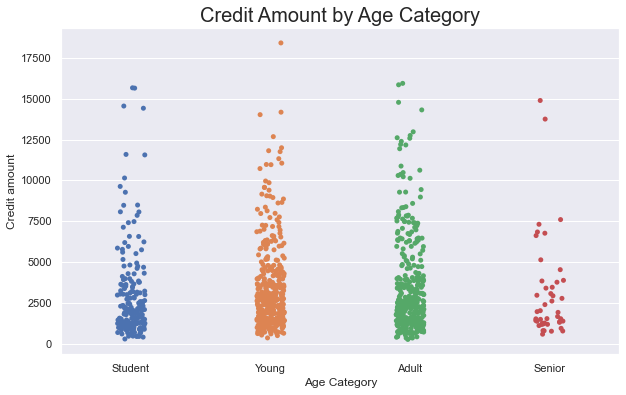

In [6]:
plt.figure(figsize=(10, 6))
plt.title("Credit Amount by Age Category", fontsize=20)
sns.stripplot(data=credit_ml_df, x='Age Category', y='Credit amount') # create strip plot to detect outliers
plt.show()

In [7]:
credit_cat = credit_ml_df.groupby('Credit Category')
pd.concat([group for (name, group) in credit_cat if name in ['greater than 17500', '15000 <= x < 17500']])

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age Category,Credit Category
95,58,male,skilled,rent,little,moderate,15945,54,business,0,Adult,15000 <= x < 17500
637,21,male,skilled,own,little,none,15653,60,radio/TV,1,Student,15000 <= x < 17500
818,43,male,highly skilled,own,little,little,15857,36,vacation/others,1,Adult,15000 <= x < 17500
887,23,male,skilled,own,little,moderate,15672,48,business,0,Student,15000 <= x < 17500
915,32,female,highly skilled,own,little,moderate,18424,48,vacation/others,0,Young,greater than 17500


In [8]:
credit_cat = credit_ml_df.groupby('Credit Category')
credit_cat.get_group('greater than 17500')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age Category,Credit Category
915,32,female,highly skilled,own,little,moderate,18424,48,vacation/others,0,Young,greater than 17500


In [9]:
credit_ml_df = credit_ml_df.drop([915], axis=0) # drop the outlier from the dataframe
pd.crosstab(credit_ml_df['Credit Category'], credit_ml_df['Age Category']).style.background_gradient(cmap=cm)

Age Category,Student,Young,Adult,Senior
Credit Category,,,,
x < 2500,114,199,198,26
2500 <= x < 5000,48,127,89,11
5000 <= x < 7500,14,40,43,5
7500 <= x < 10000,7,20,18,1
10000 <= x < 12500,3,8,11,0
12500 <= x < 15000,2,3,6,2
15000 <= x < 17500,2,0,2,0


In [10]:
from sklearn.model_selection import train_test_split

target = credit_ml_df['Risk'] # assign the 'Risk' column to a seperate variable
credit_ml_df['Credit amount'] = np.log(credit_ml_df['Credit amount']) # take the natural log of the credit variable
credit_ml_df = credit_ml_df.drop(['Risk'], axis=1) # drop the target variable from the dataframe

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(credit_ml_df, target, train_size=0.8, random_state=42)
print("Length of training data:", len(X_train))
print("Length of testing data:", len(X_test))
print("Length of total data:", len(credit_ml_df))

Length of training data: 799
Length of testing data: 200
Length of total data: 999


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
    ('normalizer', Normalizer())
])

num_attributes = ['Age', 'Credit amount', 'Duration']
cat_attributes = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age Category', 'Credit Category']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])

train_data_prepared = full_pipeline.fit_transform(X_train)
test_data_prepared = full_pipeline.fit_transform(X_test)

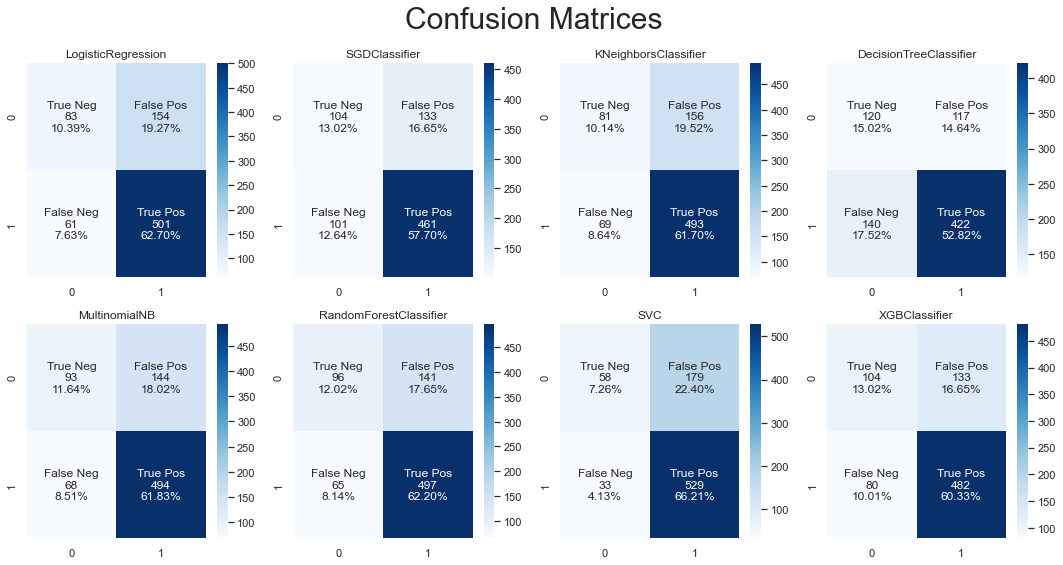

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import confusion_matrix

clf_lr = LogisticRegression(random_state=42)
clf_sgd = SGDClassifier(random_state=42)
clf_knn = KNeighborsClassifier()
clf_cart = DecisionTreeClassifier(random_state=42)
clf_nb = MultinomialNB()
clf_rf = RandomForestClassifier(random_state=42)
clf_svm = SVC(random_state=42)
clf_xgb = XGBClassifier()

# to feed the random state
seed = 7

# prepare models
models = []
models.append((clf_lr))
models.append((clf_sgd))
models.append((clf_knn))
models.append((clf_cart))
models.append((clf_nb))
models.append((clf_rf))
models.append((clf_svm))
models.append((clf_xgb))

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for model, ax in zip(models, axes.flatten()):
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    y_train_pred = cross_val_predict(model, train_data_prepared, y_train, cv=kfold)
    cf_matrix = confusion_matrix(y_train, y_train_pred)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax) # visual confusion matrix of all models
    ax.title.set_text(type(model).__name__)

#plt.title("Confusion Matrices")
fig.suptitle("Confusion Matrices", fontsize=30)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', clf_lr))
models.append(('SGD', clf_sgd))
models.append(('KNN', clf_knn))
models.append(('CART', clf_cart))
models.append(('NB', clf_nb))
models.append(('RF', clf_rf))
models.append(('SVM', clf_svm))
models.append(('XGB', clf_xgb))

# evaluate each model in turn
results = []
names = []
scoring = 'f1'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, train_data_prepared, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

LR: 0.822833 (0.031787)
SGD: 0.796623 (0.019529)
KNN: 0.812874 (0.037589)
CART: 0.764789 (0.043887)
NB: 0.822764 (0.037999)
RF: 0.827562 (0.031641)
SVM: 0.832863 (0.018406)
XGB: 0.817732 (0.034031)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', clf_lr))
models.append(('SGD', clf_sgd))
models.append(('KNN', clf_knn))
models.append(('CART', clf_cart))
models.append(('NB', clf_nb))
models.append(('RF', clf_rf))
models.append(('SVM', clf_svm))
models.append(('XGB', clf_xgb))

# evaluate each model in turn
# creating a list for the kfold CV metric scores
accuracy_results = []
precision_results = []
recall_results = []
f1_results = []

# creating a list of the average metric scores
avg_accuracy_results = []
avg_precision_results = []
avg_recall_results = []
avg_f1_results = []

names = []

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_accuracy = cross_val_score(model, train_data_prepared, y_train, cv=kfold, scoring='accuracy')
        cv_precision = cross_val_score(model, train_data_prepared, y_train, cv=kfold, scoring='precision')
        cv_recall = cross_val_score(model, train_data_prepared, y_train, cv=kfold, scoring='recall')
        cv_f1 = cross_val_score(model, train_data_prepared, y_train, cv=kfold, scoring='f1')
        accuracy_results.append(cv_accuracy)
        precision_results.append(cv_precision)
        recall_results.append(cv_recall)
        f1_results.append(cv_f1)

        avg_accuracy_results.append(cv_accuracy.mean())
        avg_precision_results.append(cv_precision.mean())
        avg_recall_results.append(cv_recall.mean())
        avg_f1_results.append(cv_f1.mean())

        names.append(name)

clf_metrics_data = {
    "Accuracy": avg_accuracy_results,
    "Precision": avg_precision_results,
    "Recall": avg_recall_results,
    "F1": avg_f1_results
}

clf_metrics_df = pd.DataFrame(clf_metrics_data, index=names) # Creating a dataframe of all the metrics for each model
clf_metrics_df.index.name = "Model"

clf_metrics_df

,Accuracy,Precision,Recall,F1
Model,,,,
LR,0.731013,0.765574,0.891771,0.822833
SGD,0.707199,0.790394,0.821375,0.796623
KNN,0.718513,0.759175,0.876424,0.812874
CART,0.678354,0.782031,0.749890,0.764789
NB,0.734731,0.775245,0.879624,0.822764
RF,0.742278,0.779212,0.884280,0.827562
SVM,0.734747,0.747404,0.942065,0.832863
XGB,0.733497,0.783841,0.858026,0.817732


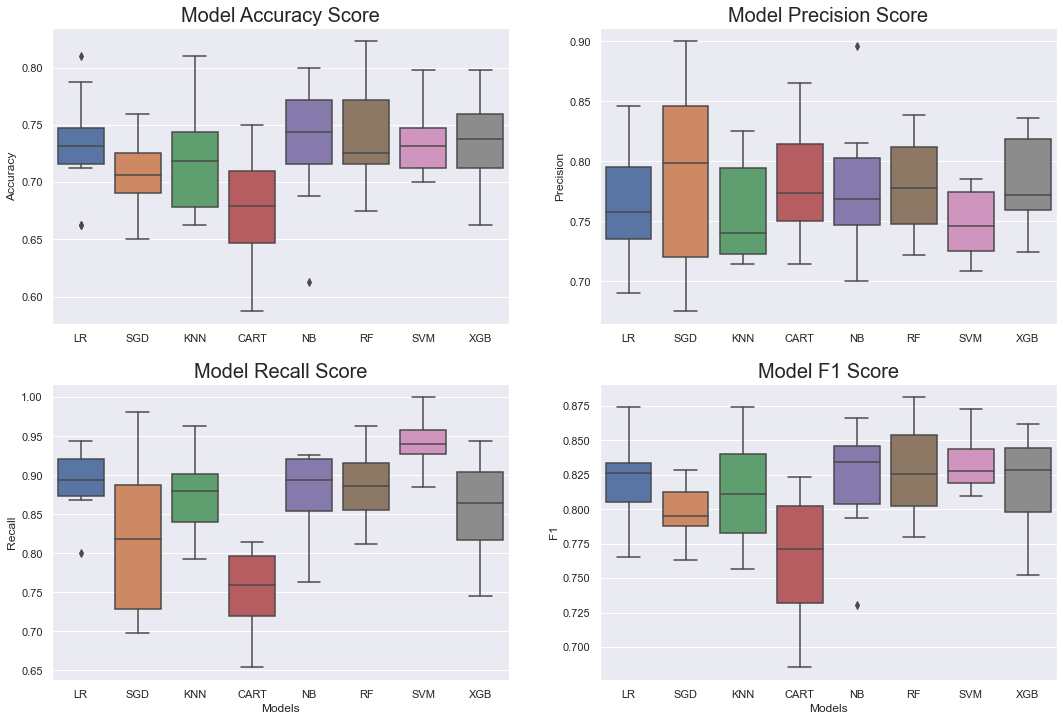

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
sns.boxplot(data=accuracy_results, ax=ax1)
ax1.set_xticklabels(names)
ax1.set_ylabel("Accuracy")
ax1.set_title("Model Accuracy Score", fontsize=20)

sns.boxplot(data=precision_results, ax=ax2)
ax2.set_ylabel("Precision")
ax2.set_xticklabels(names)
ax2.set_title("Model Precision Score", fontsize=20)

sns.boxplot(data=recall_results, ax=ax3)
ax3.set_ylabel("Recall")
ax3.set_xticklabels(names)
ax3.set_xlabel("Models")
ax3.set_title("Model Recall Score", fontsize=20)

sns.boxplot(data=f1_results, ax=ax4)
ax4.set_ylabel("F1")
ax4.set_xticklabels(names)
ax4.set_xlabel("Models")
ax4.set_title("Model F1 Score", fontsize=20)
plt.show()

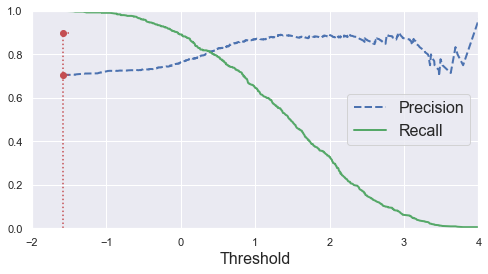

In [16]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-2, 4, 0, 1])             # Not shown

y_scores_lr = cross_val_predict(clf_lr, train_data_prepared, y_train, cv=kfold, method='decision_function')
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_train, y_scores_lr)

#recall_90_precision = recalls_lr[np.argmax(precisions_lr >= 0.9)]
#threshold_90_precision = thresholds_lr[np.argmax(precisions_lr >= 0.9)]

precision_90_recall = precisions_lr[np.argmax(recalls_lr >= 0.9)]
threshold_90_recall = thresholds_lr[np.argmax(recalls_lr >= 0.9)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions_lr, recalls_lr, thresholds_lr)
plt.plot([threshold_90_recall, threshold_90_recall], [0., 0.9], "r:")                 # Not shown
plt.plot([-1.5, threshold_90_recall], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-1.5, threshold_90_recall], [precision_90_recall, precision_90_recall], "r:")# Not shown
plt.plot([threshold_90_recall], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_recall], [precision_90_recall], "ro")                             # Not shown
plt.show()

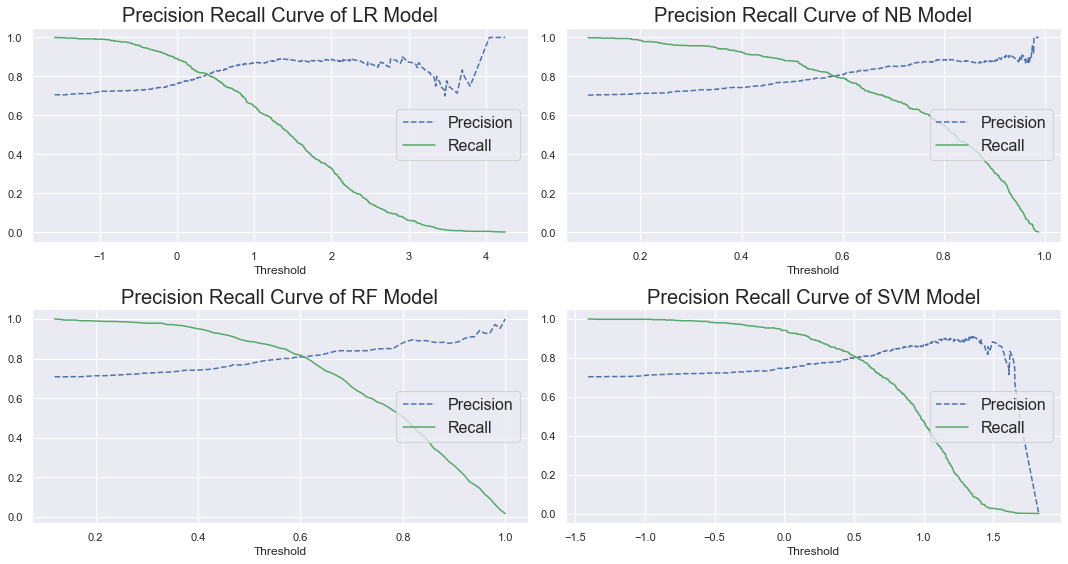

In [17]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = cross_val_predict(clf_lr, train_data_prepared, y_train, cv=kfold, method='decision_function')
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_train, y_scores_lr)

y_probas_nb = cross_val_predict(clf_nb, train_data_prepared, y_train, cv=kfold, method='predict_proba')
y_scores_nb = y_probas_nb[:, 1] # score = proba of positive class
precisions_nb, recalls_nb, thresholds_nb = precision_recall_curve(y_train, y_scores_nb)

y_probas_rf = cross_val_predict(clf_rf, train_data_prepared, y_train, cv=kfold, method='predict_proba')
y_scores_rf = y_probas_rf[:, 1] # score = proba of positive class
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train, y_scores_rf)

y_scores_svm = cross_val_predict(clf_svm, train_data_prepared, y_train, cv=kfold, method='decision_function')
precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(y_train, y_scores_svm)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
ax1.plot(thresholds_lr, precisions_lr[:-1], 'b--', label="Precision")
ax1.plot(thresholds_lr, recalls_lr[:-1], 'g-', label="Recall")
ax1.legend(loc="center right", fontsize=16)        
ax1.set_title("Precision Recall Curve of LR Model", fontsize=20)
ax1.set_xlabel("Threshold")

ax2.plot(thresholds_nb, precisions_nb[:-1], 'b--', label="Precision")
ax2.plot(thresholds_nb, recalls_nb[:-1], 'g-', label="Recall")
ax2.legend(loc="center right", fontsize=16) 
ax2.set_title("Precision Recall Curve of NB Model", fontsize=20)
ax2.set_xlabel("Threshold")

ax3.plot(thresholds_rf, precisions_rf[:-1], 'b--', label="Precision")
ax3.plot(thresholds_rf, recalls_rf[:-1], 'g-', label="Recall")
ax3.legend(loc="center right", fontsize=16) 
ax3.set_title("Precision Recall Curve of RF Model", fontsize=20)
ax3.set_xlabel("Threshold")

ax4.plot(thresholds_svm, precisions_svm[:-1], 'b--', label="Precision")
ax4.plot(thresholds_svm, recalls_svm[:-1], 'g-', label="Recall")
ax4.legend(loc="center right", fontsize=16) 
ax4.set_title("Precision Recall Curve of SVM Model", fontsize=20)
ax4.set_xlabel("Threshold")

plt.tight_layout()
plt.show()

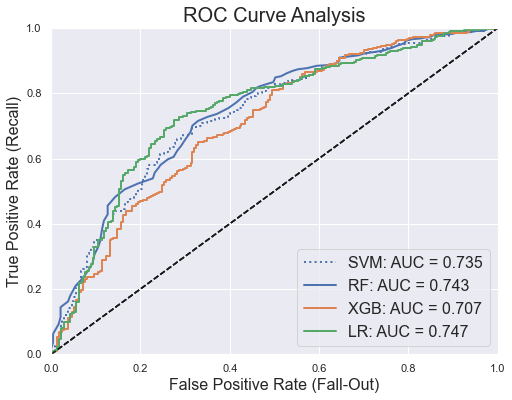

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

y_scores_svm = cross_val_predict(SVC(), train_data_prepared, y_train, cv=kfold, method='decision_function')
fpr_svm, tpr_svm, thresholds = roc_curve(y_train, y_scores_svm)
auc_svm = roc_auc_score(y_train, y_scores_svm)

y_probas_forest = cross_val_predict(RandomForestClassifier(n_estimators=100, random_state=42), train_data_prepared, y_train, cv=kfold, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)
auc_forest = roc_auc_score(y_train, y_scores_forest)

y_probas_xgb = cross_val_predict(XGBClassifier(), train_data_prepared, y_train, cv=kfold, method='predict_proba')
y_scores_xgb = y_probas_xgb[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_scores_xgb)
auc_xgb = roc_auc_score(y_train, y_scores_xgb)

y_scores_LR = cross_val_predict(LogisticRegression(random_state=42), train_data_prepared, y_train, cv=kfold, method='decision_function')
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_train, y_scores_LR)
auc_LR = roc_auc_score(y_train, y_scores_LR)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)

# recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, "b:", linewidth=2, label="SVM: AUC = %0.3f" % auc_svm)
plot_roc_curve(fpr_forest, tpr_forest, "RF: AUC = %0.3f" % auc_forest)
plot_roc_curve(fpr_xgb, tpr_xgb, "XGB: AUC = %0.3f" % auc_xgb)
plot_roc_curve(fpr_LR, tpr_LR, "LR: AUC = %0.3f" % auc_LR)
plt.grid(True)
plt.title("ROC Curve Analysis", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score

y_train_pred_lr = cross_val_predict(LogisticRegression(), train_data_prepared, y_train, cv=kfold) #cross-val predict
precision_score(y_train, y_train_pred_lr)

0.7648854961832061

In [20]:
recall_score(y_train, y_train_pred_lr)

0.891459074733096